Loaded data from ./SymTestSys.csv


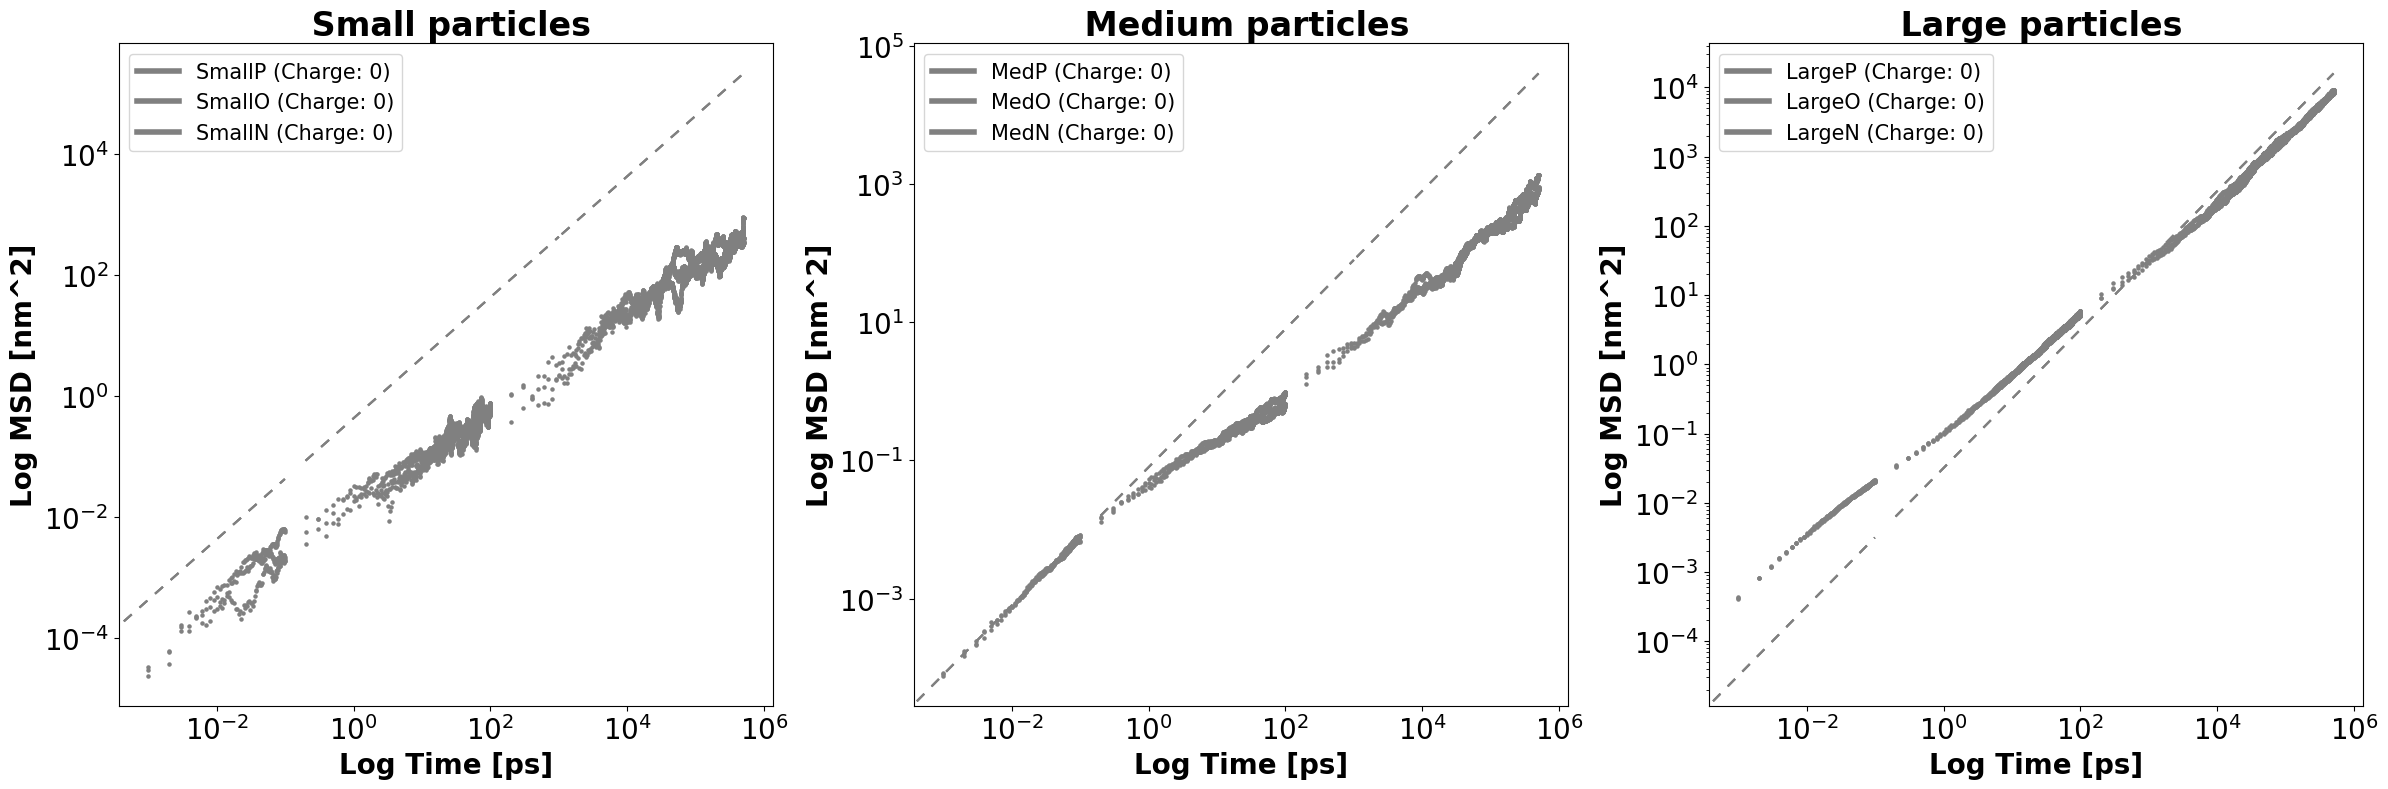

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import glob

plt.rcParams.update({
    'axes.titlesize': 24,
    'axes.titleweight': 'bold',
    'axes.labelsize': 20,
    'axes.labelweight': 'bold',
    'grid.alpha': 0.5,
    'legend.fontsize': 15
})

kT = 1.0
Viscosity = 1.0
directory = './'

sys_csv_files = glob.glob(directory + '*Sys*.csv')

if sys_csv_files:
    sys_data = pd.read_csv(sys_csv_files[0])
    print(f"Loaded data from {sys_csv_files[0]}")
else:
    print("No files found matching the pattern *Sys*.csv")

sys_data = sys_data.rename(columns={' Radius': 'Radius'})

def categorize_radius(radius):
    if radius <= 1.0:
        return 'small'
    elif radius <= 5.0:
        return 'medium'
    else:
        return 'large'

sys_data['Category'] = sys_data['Radius'].apply(categorize_radius)
grouped_species = sys_data.groupby('Category').apply(lambda x: list(x['Name'])).to_dict()
species_charge = sys_data.set_index('Name')['Charge'].to_dict()
species_radius = sys_data.set_index('Name')['Radius'].to_dict()

def find_msd_files(species_name, directory='.'):
    pattern = f'MSD_{species_name}_trajectory_'
    return [os.path.join(directory, f) for f in os.listdir(directory) if f.startswith(pattern) and f.endswith('.csv')]

def plot_data(grouped_species, species_charge, species_radius, directory='.'):
    fig, axs = plt.subplots(1, 3, figsize=(24, 8))
    categories = ['small', 'medium', 'large']
    bold_linestyle = (0, (5, 5))  # Bold and large spaced-out dashes

    for ax, category in zip(axs, categories):
        species_list = grouped_species.get(category, [])
        ax.tick_params(axis='both', labelsize=20)
        ax.set_xscale('log')
        ax.set_yscale('log')
        legend_entries = []  # List to hold legend entries

        for i, species in enumerate(species_list):
            files = find_msd_files(species, directory)
            color = 'red' if species_charge[species] > 0 else 'blue' if species_charge[species] < 0 else 'gray'

            for file in files:
                data = pd.read_csv(file)
                time = data.iloc[:, 0]
                msd = data.iloc[:, 1]
                ax.scatter(time, msd, color=color, s=5)

                # Create a legend entry for each species
                if file == files[0]:  # Add only once per species
                    legend_entries.append((plt.Line2D([0], [0], color=color, lw=4), f'{species} (Charge: {species_charge[species]})'))

                D_Exp = kT / (Viscosity * np.pi * species_radius[species])
                # Plot trend lines without adding them to the legend
                #ax.plot(time[time <= 1E-1], D_Exp * time[time <= 1E-1]**2, color='black', linestyle=bold_linestyle, linewidth=1)
                
                ax.plot(time[time <= 1E-1], D_Exp * time[time <= 1E-1], color=color, linestyle=bold_linestyle, linewidth=1.5)
                ax.plot(time[(time > 1E-1) & (time < 1E3)], D_Exp * time[(time > 1E-1) & (time < 1E3)], color=color, linestyle=bold_linestyle, linewidth=1.5)
                ax.plot(time[time >= 1E3], D_Exp * time[time >= 1E3], color=color, linestyle=bold_linestyle, linewidth=1.5)

                #ax.plot(time[time >= 1E3], D_Exp * time[time >= 1E3]**0.5, color='black', linestyle=bold_linestyle, linewidth=1)

        # Add custom legend for each subplot
        ax.legend(handles=[entry[0] for entry in legend_entries], labels=[entry[1] for entry in legend_entries], loc='upper left')
        ax.set_xlabel('Log Time [ps]')
        ax.set_ylabel('Log MSD [nm^2]')
        ax.set_title(f' {category.capitalize()} particles')

    plt.tight_layout()
    plt.savefig('Combined_MSD.svg', format='svg')
    plt.show()

plot_data(grouped_species, species_charge, species_radius, directory)


<>:38: SyntaxWarning: invalid escape sequence '\m'
<>:38: SyntaxWarning: invalid escape sequence '\s'
<>:59: SyntaxWarning: invalid escape sequence '\m'
<>:59: SyntaxWarning: invalid escape sequence '\s'
<>:38: SyntaxWarning: invalid escape sequence '\m'
<>:38: SyntaxWarning: invalid escape sequence '\s'
<>:59: SyntaxWarning: invalid escape sequence '\m'
<>:59: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_3092371/1494139642.py:38: SyntaxWarning: invalid escape sequence '\m'
  equation_num_constituents = f'Log-Normal($\mu$={mu_num_constituents:.2f}, $\sigma$={sigma_num_constituents:.2f})'
/tmp/ipykernel_3092371/1494139642.py:38: SyntaxWarning: invalid escape sequence '\s'
  equation_num_constituents = f'Log-Normal($\mu$={mu_num_constituents:.2f}, $\sigma$={sigma_num_constituents:.2f})'
/tmp/ipykernel_3092371/1494139642.py:59: SyntaxWarning: invalid escape sequence '\m'
  equation_charge = f'Log-Normal($\mu$={mu_charge:.2f}, $\sigma$={sigma_charge:.2f})'
/tmp/ipykernel_3092

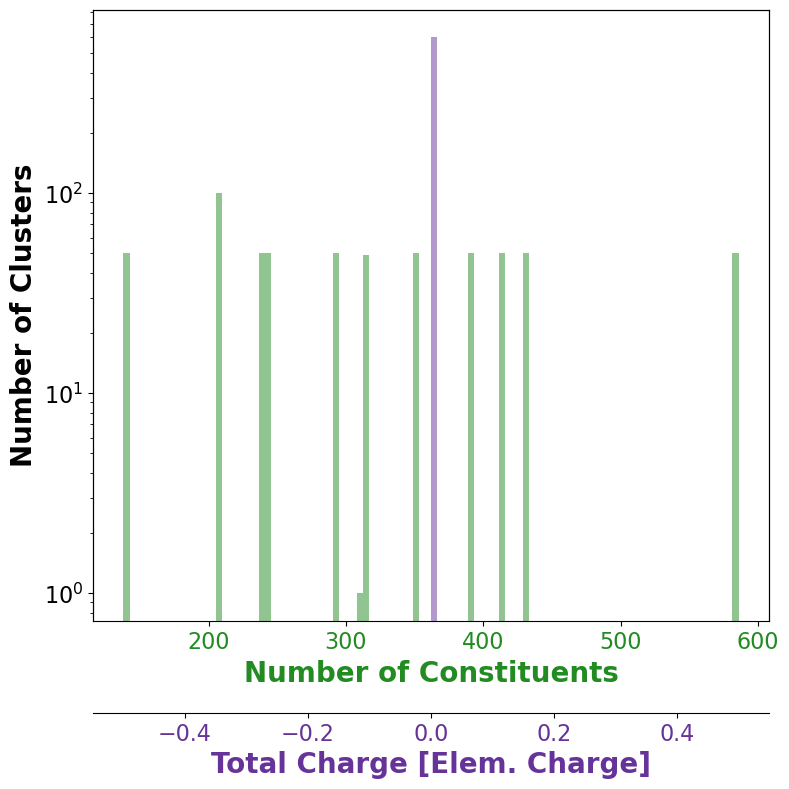

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import lognorm

plt.rcParams.update({
    'axes.titlesize': 24,
    'axes.titleweight': 'bold',
    'axes.labelsize': 20,
    'axes.labelweight': 'bold',
    'grid.alpha': 0.5,
    'legend.fontsize': 15
})

Cluster_Statistics_file = './Cluster_Statistics.csv'

def plot_cluster_histograms_and_fits(file_path, fit_data=True):
    # Load the data
    cluster_data = pd.read_csv(file_path)
    
    # Initialize the plot
    fig, ax1 = plt.subplots(figsize=(8, 8))

    # Plot for Num_Constituents
    color_num_constituents = 'forestgreen'
    data_num_constituents = cluster_data['Num_Constituents']
    ax1.hist(data_num_constituents, bins=100, color=color_num_constituents, log=True, alpha=0.5)
    ax1.set_xlabel('Number of Constituents', color=color_num_constituents)
    ax1.set_ylabel('Number of Clusters', color='black')
    ax1.tick_params(axis='x', labelcolor=color_num_constituents)

    if fit_data:
        # Fit for Num_Constituents
        shape_num_constituents, loc_num_constituents, scale_num_constituents = lognorm.fit(data_num_constituents, floc=0)
        mu_num_constituents = np.log(scale_num_constituents)  # Convert scale parameter back to mu
        sigma_num_constituents = shape_num_constituents
        # Display equation for Num_Constituents fit on the top left
        equation_num_constituents = f'Log-Normal($\mu$={mu_num_constituents:.2f}, $\sigma$={sigma_num_constituents:.2f})'
        ax1.text(0.05, 0.95, equation_num_constituents, transform=ax1.transAxes, color=color_num_constituents, verticalalignment='top')

    # Plot for Total_Charge
    abs_charge = np.abs(cluster_data['Total_Charge'])
    ax2 = ax1.twiny()
    ax2.hist(-abs_charge, bins=100, color='rebeccapurple', log=True, alpha=0.5)
    ax2.tick_params(axis='x', labelcolor='rebeccapurple')
    ax2.xaxis.set_label_position('bottom')
    ax2.xaxis.tick_bottom()
    ax2.spines["bottom"].set_position(("axes", -0.15))
    ax2.set_xlabel('Total Charge [Elem. Charge]', color='rebeccapurple')
    ax1.tick_params(axis='both', labelsize=16)
    ax2.tick_params(axis='both', labelsize=16)

    if fit_data:
        # Fit for Total_Charge
        shape_charge, loc_charge, scale_charge = lognorm.fit(abs_charge, floc=0)
        mu_charge = np.log(scale_charge)  # Convert scale parameter back to mu
        sigma_charge = shape_charge
        # Display equation for Total_Charge fit on the top right
        equation_charge = f'Log-Normal($\mu$={mu_charge:.2f}, $\sigma$={sigma_charge:.2f})'
        ax2.text(0.95, 0.95, equation_charge, transform=ax2.transAxes, color='rebeccapurple', horizontalalignment='right', verticalalignment='top')

    fig.tight_layout()
    plt.savefig(f'Cluster_Histogram_Fits_Equations.svg', format='svg')
    plt.show()

# Example usage
plot_cluster_histograms_and_fits(Cluster_Statistics_file, fit_data=False)  # Set fit_data=False to plot without fitting


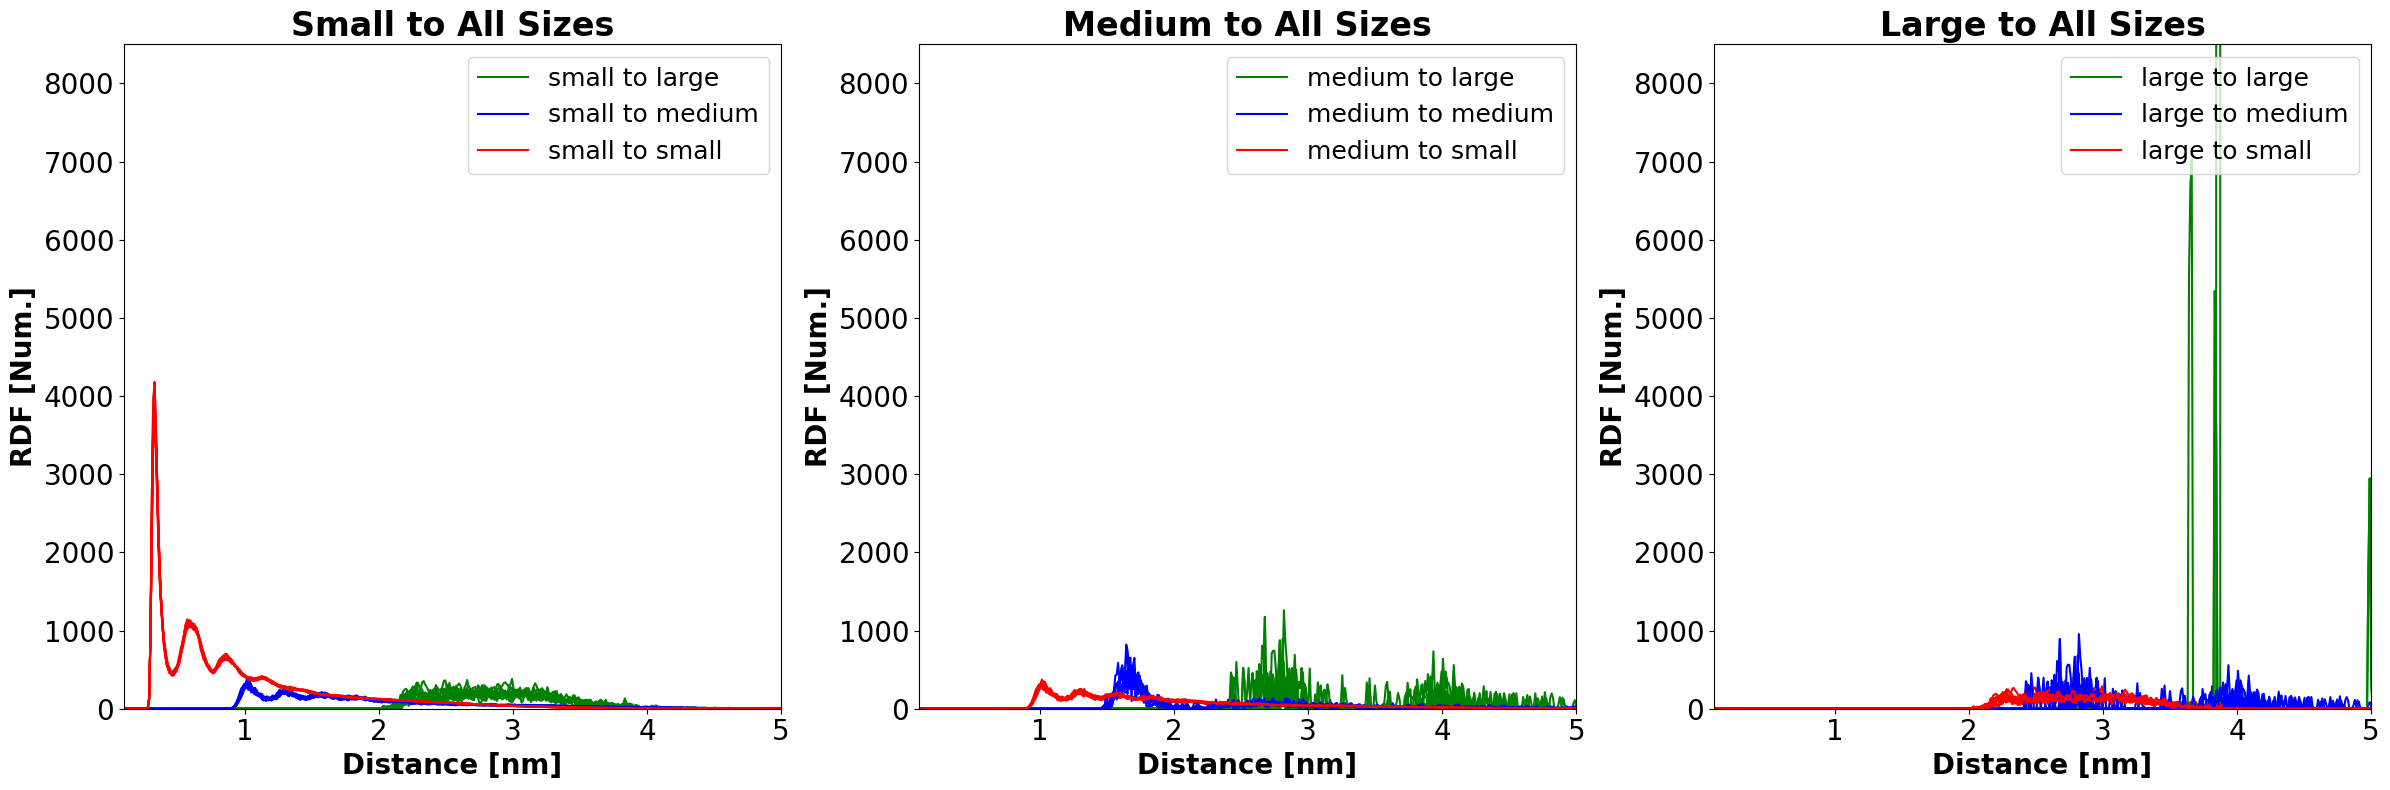

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import glob


plt.rcParams.update({
    'axes.titlesize': 24,
    'axes.titleweight': 'bold',
    'axes.labelsize': 20,
    'axes.labelweight': 'bold',
    'grid.alpha': 0.5,
    'legend.fontsize': 15
})
legend_font_size = 18 
# Load system data with species, charges, and radii
sys_csv_files = glob.glob('*Sys.csv')
if sys_csv_files:
    sys_data = pd.read_csv(sys_csv_files[0])
    sys_data = sys_data.rename(columns=lambda x: x.strip())  # Ensure correct column naming
    
    # Categorize species by size
    small_threshold, medium_threshold = 1.0, 5.0  # Adjust as needed
    sys_data['Size'] = sys_data['Radius'].apply(lambda x: 'small' if x <= small_threshold else ('medium' if x <= medium_threshold else 'large'))
    
    # Maps
    species_size = sys_data.set_index('Name')['Size'].to_dict()

# Load RDF data
rdf_data = pd.read_csv('./RDFs.csv')  # Adjust path as needed

# Adjusted plotting code with new requirements
fig, axs = plt.subplots(1, 3, figsize=(24, 8))
titles = ['small', 'medium', 'large']

# Define a color for each size class of j
colors = {'small': 'red', 'medium': 'blue', 'large': 'green'}

for col in rdf_data.columns[:-1]:  # Exclude the 'r' column
    _, i, j = col.split('_')
    i_size = species_size.get(i)
    j_size = species_size.get(j)
    if i_size and j_size:  # Ensure size is determined for both i and j
        idx = titles.index(i_size)
        color = colors[j_size]
        axs[idx].plot(rdf_data['r']*20, rdf_data[col], color=color, label=f'{i_size} to {j_size}') 

# Set titles, labels, and legends
for i, ax in enumerate(axs):
    ax.set_title(f'{titles[i].capitalize()} to All Sizes')
    ax.set_xlabel('Distance [nm]')
    ax.set_ylabel('RDF [Num.]')
    ax.tick_params(axis='both', labelsize=20)
    ax.set_ylim(0, 8500)
    ax.set_xlim(0.1, 5)  # Limit y-axis to 35000
    # Simplify legend labels to only include unique labels
    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    ax.legend(*zip(*unique), loc='upper right', fontsize=legend_font_size)

plt.tight_layout()
plt.savefig("Pairwise_RDFs_ij.svg", bbox_inches='tight')
plt.show()